<a href="https://colab.research.google.com/github/kamaliniPonnuru/Activity6_Datasets/blob/main/FE_FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
# TensorFlow / Keras - Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Scikit-learn - Classical ML & Metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Image Processing
import cv2
from skimage.feature import graycomatrix, graycoprops
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Optimization & Tuning
import keras_tuner as kt

# Core Python
import numpy as np
import os
import random
import shutil

import keras
from keras.utils import plot_model


In [ ]:
os.environ['KAGGLE_USERNAME']='kamaliniponnuru'
os.environ['KAGGLE_KEY']='42798df4b18135c13c8f25e7b66295b5'
# Downloads the Multi Cancer dataset from Kaggle directly to the Colab
! kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone
#unzip the multi cancer dataset folder
! unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [ ]:
#counts the total number of images in the cyst kidney folder
total_cyst_kidney_files = len(os.listdir("/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"))
#counts the total number of images in the normal kidney folder
total_normal_kidney_files= len(os.listdir("/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"))
#counts the total number of images in the stone kidney folder
total_stone_kidney_files= len(os.listdir("/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"))
#counts the total number of images in the tumor kidney folder
total_tumor_kidney_files= len(os.listdir("/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"))

In [ ]:
#bar graph shows the distribution of data for the total number of files present in the dataset
bar_graph = px.bar(x=['Cyst Kidney','Normal Kidney', 'Stone Kidney','Tumor Kidney'], y=[total_cyst_kidney_files,total_normal_kidney_files,total_stone_kidney_files, total_tumor_kidney_files],labels={'x': 'Types', 'y': 'Total images'},
title='Bar graph for total number of files present in the dataset'
)
bar_graph.update_traces(marker_color=['rgb(255, 255, 0)', 'rgb(204, 0, 0)'])

bar_graph.show()

In [ ]:
#Below code splits the total number of normal kidney and tumor kidney files into 80:20 ratio for training set and testing set
# 80% for training set in different kidney class
train_cyst_kidney = int(0.8*total_cyst_kidney_files)
train_normal_kidney = int(0.8*total_normal_kidney_files)
train_stone_kidney = int(0.8*total_stone_kidney_files)
train_tumor_kidney= int(0.8*total_tumor_kidney_files)
# 20% for testing set in different kidney class
test_cyst_kidney=int(0.2*total_cyst_kidney_files)
test_normal_kidney=int(0.2*total_normal_kidney_files)
test_stone_kidney=int(0.2*total_stone_kidney_files)
test_tumor_kidney=int(0.2*total_tumor_kidney_files)

In [ ]:
#bar graph shows the distribution of data in different sets i.e training_normal, training_tumor, testing_normal and testing_tumor
bar_graph_train_test = px.bar(x=['Training set- Cyst Kidney','Training set- Normal Kidney','Training set- Stone Kidney','Training set- Tumor Kidney','Testing set- Cyst Kidney','Testing set- Normal Kidney','Testing set- Stone Kidney','Testing set- Tumor Kidney'], y=[train_cyst_kidney,train_normal_kidney,train_stone_kidney,train_tumor_kidney,test_cyst_kidney,test_normal_kidney,test_stone_kidney,test_tumor_kidney],labels={'x': 'Training & Testing Sets', 'y': 'Total images'},
title='Bar graph for total number of files present in each training and testing dataset'
)
bar_graph_train_test.update_traces(marker_color=['rgb(204, 0, 0)', 'rgb(204, 0, 0)','rgb(204, 0, 0)','rgb(204, 0, 0)'])
bar_graph_train_test.show()


In [ ]:
# Set paths
source_dir = 'CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
target_dir = 'dataset_split'

# Create folders
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
for category in ['train', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(target_dir, category, cls), exist_ok=True)

# Count files and calculate splits
def get_split_counts(folder):
    files = os.listdir(folder)
    total = len(files)
    train_count = int(0.8 * total)
    test_count = total - train_count
    return train_count, test_count, files

# Shuffle & Copy files to train/test
for cls in classes:
    class_path = os.path.join(source_dir, cls)
    train_count, test_count, files = get_split_counts(class_path)
    random.shuffle(files)

    train_files = files[:train_count]
    test_files = files[train_count:]

    # Copy training files
    for f in train_files:
        src = os.path.join(class_path, f)
        dst = os.path.join(target_dir, 'train', cls, f)
        shutil.copy(src, dst)

    # Copy testing files
    for f in test_files:
        src = os.path.join(class_path, f)
        dst = os.path.join(target_dir, 'test', cls, f)
        shutil.copy(src, dst)

print("✅ All images split into 80:20 for train and test successfully!")

✅ All images split into 80:20 for train and test successfully!


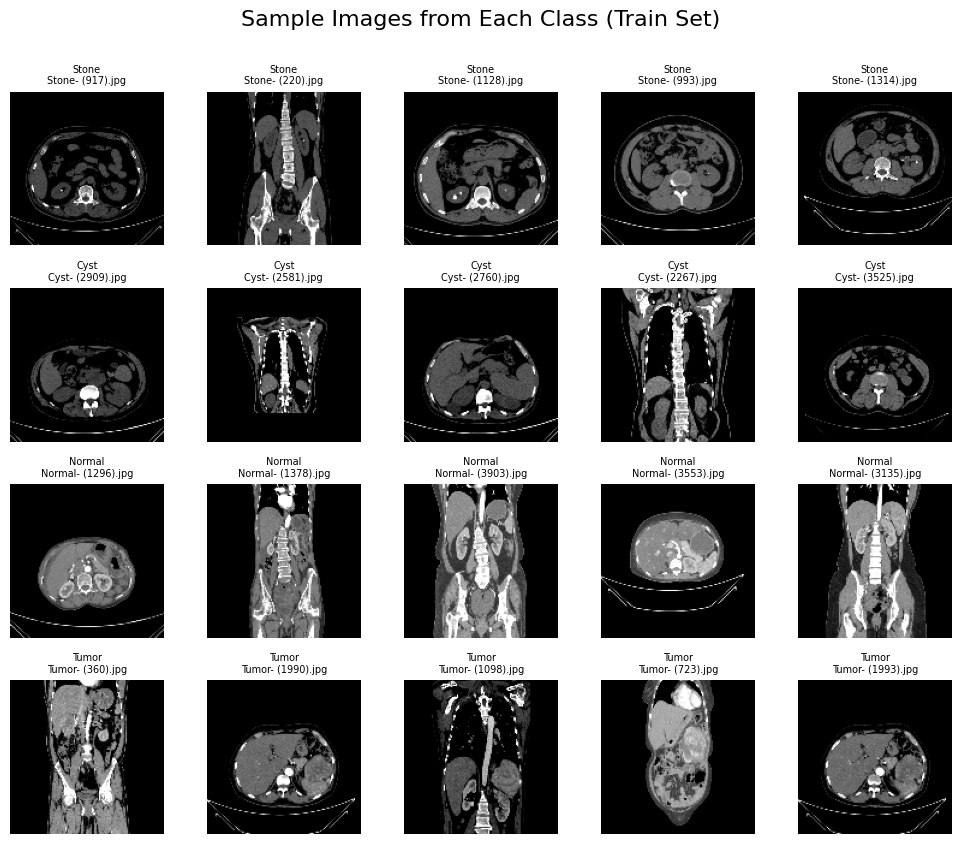

In [ ]:
# Path to your train directory
train_dir = 'dataset_split/train'
test_dir = 'dataset_split/test'

# Parameters
classes = os.listdir(train_dir)
num_classes = len(classes)
samples_per_class = 5
img_size = (128, 128)

# Set up the plot
plt.figure(figsize=(samples_per_class * 2, num_classes * 2))

i = 1
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    image_files = random.sample(os.listdir(class_path), samples_per_class)

    for img_name in image_files:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)

        plt.subplot(num_classes, samples_per_class, i)
        plt.imshow(img)
        plt.axis('off')
        # Show both class name and file name
        title = f"{cls}\n{img_name}"
        plt.title(title, fontsize=7)
        i += 1

plt.tight_layout()
plt.suptitle("Sample Images from Each Class (Train Set)", fontsize=16, y=1.05)
plt.show()

In [ ]:
# Train + Validation ImageDataGenerator
trainDatagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values
    zoom_range=0.5,                # Random zoom
    rotation_range=20,            # Random rotation (degrees)
    horizontal_flip=True,         # Random horizontal flip
    brightness_range=[0.8, 1.2],  # Adjust brightness
    width_shift_range=0.2,        # Horizontal shift
    height_shift_range=0.2,       # Vertical shift
    fill_mode='nearest',          # Fill pixels after transformation
    validation_split=0.2          # Split train/val (80/20)
)

# Test ImageDataGenerator (no augmentation)
testDatagen = ImageDataGenerator(rescale=1./255)

# Flow from directories
train_generator = trainDatagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # MULTI-CLASS classification
    subset='training',
    color_mode='grayscale',
    shuffle=True
)

validation_generator = trainDatagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale',
    shuffle=True
)

test_generator = testDatagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)


Found 7965 images belonging to 4 classes.
Found 1990 images belonging to 4 classes.
Found 2491 images belonging to 4 classes.


In [ ]:
train_generator.class_indices

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

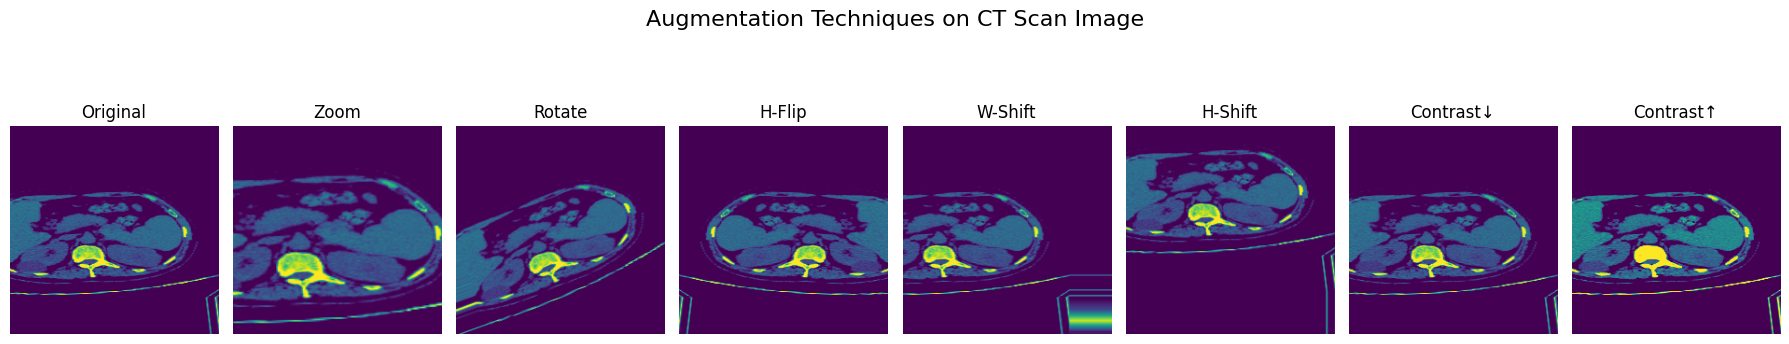

In [ ]:
# Get one image from a training batch
images, labels = next(train_generator)
original = images[0]

# Helper function for contrast adjustment
def adjust_contrast(img, factor):
    mean = np.mean(img, axis=(0,1), keepdims=True)
    return np.clip((img - mean) * factor + mean, 0, 1)

# Augmentation techniques
augmentations = {
    "Original": original,
    "Zoom": train_generator.image_data_generator.apply_transform(original, {'zx': 0.7, 'zy': 0.7}),
    "Rotate": train_generator.image_data_generator.apply_transform(original, {'theta': 20}),
    "H-Flip": np.fliplr(original),
    "W-Shift": train_generator.image_data_generator.apply_transform(original, {'tx': 0.2 * original.shape[0]}),
    "H-Shift": train_generator.image_data_generator.apply_transform(original, {'ty': 0.2 * original.shape[1]}),
    "Contrast↓": adjust_contrast(original, 0.6),
    "Contrast↑": adjust_contrast(original, 1.5)
}

# Plotting
plt.figure(figsize=(18, 4))
for i, (title, aug_img) in enumerate(augmentations.items()):
    plt.subplot(1, len(augmentations), i + 1)
    plt.imshow(aug_img)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Augmentation Techniques on CT Scan Image", fontsize=16, y=1.05)
plt.show()

In [ ]:
# Create a Sequential model
model = Sequential()

# Convolutional Layer 1: 32 filters, each of size (3, 3), ReLU activation
# Input shape: (224, 224, 3)
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 1)))
# MaxPooling Layer 1: Pooling window size (4, 4)
model.add(MaxPooling2D(pool_size=(4, 4)))
# Convolutional Layer 2: 32 filters, each of size (3, 3), ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu'))
# MaxPooling Layer 2: Pooling window size (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Convolutional Layer 3: 64 filters, each of size (3, 3), ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))
# MaxPooling Layer 3: Pooling window size (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Convolutional Layer 4: 64 filters, each of size (3, 3), ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))
# MaxPooling Layer 4: Pooling window size (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout Layer: Helps prevent overfitting by randomly deactivating 15% of neurons
model.add(Dropout(0.15))
# Convolutional Layer 5: 128 filters, each of size (3, 3), ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))
# MaxPooling Layer 5: Pooling window size (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Flatten the output to prepare for fully connected layers
model.add(Flatten())
# Fully Connected Layer 1: 256 units, ReLU activation
model.add(Dense(units=256, activation='relu'))
# Dropout Layer: Helps prevent overfitting by randomly deactivating 30% of neurons
model.add(Dropout(0.3))
# Fully Connected Layer 2: 128 units, ReLU activation
model.add(Dense(units=128, activation='relu'))
# Fully Connected Layer 3: 64 units, ReLU activation
model.add(Dense(units=64, activation='relu'))
# Output Layer: Binary classification with a sigmoid activation function
model.add(Dense(units=4, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 53, 53, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,284 (833.14 KB)

 Trainable params: 213,284 (833.14 KB)

 Non-trainable params: 0 (0.00 B)

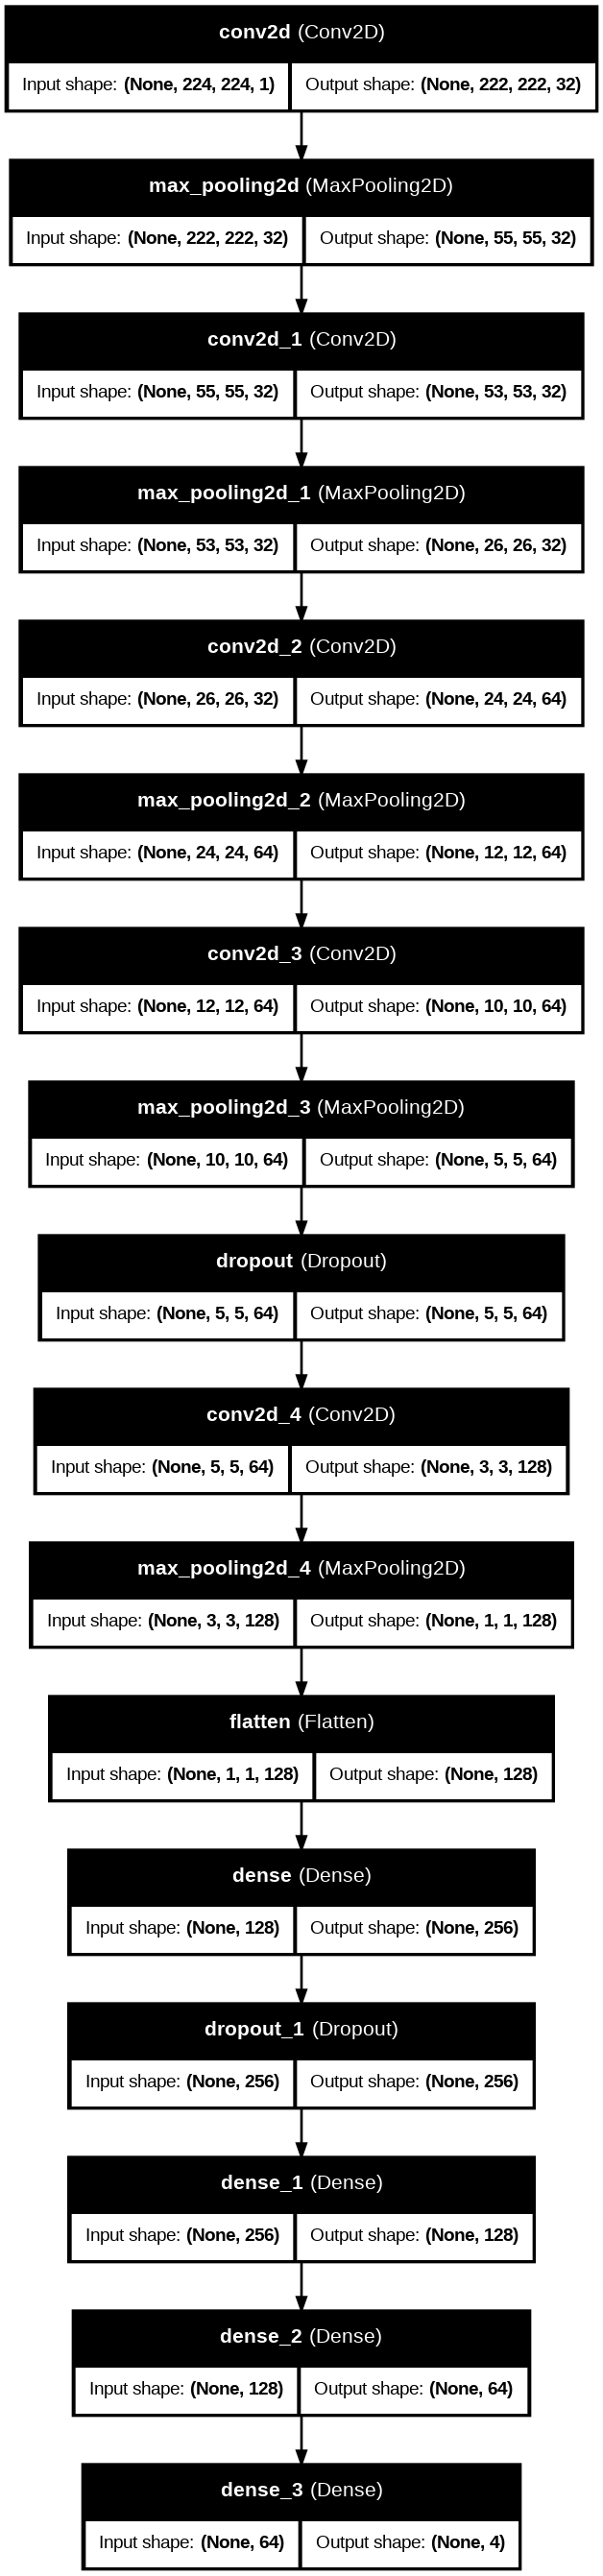

In [ ]:
keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)
#model

In [ ]:
#compile the model
model.compile(Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Train the model on the provided training data generator
# for a specified number of epochs
# Validate the model's performance using the validation data generator.
# Optionally, you can include callbacks for monitoring and early stopping.
history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = validation_generator,
                    callbacks=[early_stopping]
                    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - accuracy: 0.4554 - loss: 1.2676 - val_accuracy: 0.5121 - val_loss: 1.1939
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - accuracy: 0.6308 - loss: 0.9575 - val_accuracy: 0.5131 - val_loss: 1.2063
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6420 - loss: 0.9258 - val_accuracy: 0.6090 - val_loss: 1.1318
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 364s 1s/step - accuracy: 0.6517 - loss: 0.8926 - val_accuracy: 0.6156 - val_loss: 1.1252
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6709 - loss: 0.8484 - val_accuracy: 0.5809 - val_loss: 1.1115
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.6664 - loss: 0.8401 - val_accuracy: 0.6201 - val_loss: 1.1288
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.6865 - loss: 0.8022 - val_accuracy: 0.6201 - val_loss: 1.0806
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 370s 1s/step - accuracy: 0.6889 - loss: 0.7891 - 

In [ ]:
#generate training vs validation loss curve
def lossCurve(ht):
  plots.plot(ht.history['loss'])
  plots.plot(ht.history['val_loss'])
  plots.legend(['training','validation'])
  plots.title('Training and validation loss')
  plots.xlabel('epoch')
lossCurve(history)

In [ ]:
#generate training vs validation accuracy curve
def accuracyCurve(ht):
  plots.plot(ht.history['accuracy'])
  plots.plot(ht.history['val_accuracy'])
  plots.legend(['training','validation'])
  plots.title('Training and validation accuracy')
  plots.xlabel('epoch')

accuracyCurve(history)

In [ ]:
# Evaluate the final model on the test set
def evaluate_model(model):
  test_loss, test_acc = model.evaluate(test_generator)
  print(f'Test accuracy: {test_acc}, Test loss: {test_loss}')

evaluate_model(model)

In [ ]:
def get_predictions1(trained_model, test_generator):
    # Predict class probabilities
    y_pred_probs = trained_model.predict(test_generator, verbose=1)

    # Get predicted class indices
    y_pred = np.argmax(y_pred_probs, axis=1)

    # True class indices from the generator
    y_true = test_generator.classes

    # Class label names
    class_labels = list(test_generator.class_indices.keys())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

get_predictions1(model, test_generator) #MODEL1

In [ ]:
def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (224, 224))

    # GLCM Features
    glcm = graycomatrix(img_resized, [5], [0], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]

    # Intensity Features
    mean_intensity = np.mean(img_resized)
    std_intensity = np.std(img_resized)

    # Shape Features (contour area and compactness)
    _, thresh = cv2.threshold(img_resized, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        compactness = (perimeter**2) / (4 * np.pi * area) if area != 0 else 0
    else:
        area = 0
        compactness = 0

    return [contrast, homogeneity, energy, mean_intensity, std_intensity, area, compactness]

In [ ]:
# Load dataset
data_dir = "dataset_split/train"
classes = os.listdir(data_dir)
X, y = [], []

label_map = {cls: idx for idx, cls in enumerate(classes)}

for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    for file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, file)
        try:
            features = extract_features(img_path)
            X.append(features)
            y.append(label_map[cls])
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

X = np.array(X)
y = np.array(y)

In [ ]:
# Train a classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


# Evaluate performance
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

# Plot accuracy bar chart (as RF doesn't use epochs)
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['green', 'orange'])
plt.title("Random Forest Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Manual Features + RandomForest")
plt.show()

In [ ]:
def get_predictions2(model, X_test, y_test, label_map):
    y_pred = model.predict(X_test)
    class_labels = list(label_map.keys())

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - RandomForest (Manual Features)')
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, target_names=class_labels))

  get_predictions2(clf, X_test, y_test, label_map)


In [ ]:
import joblib
joblib.dump(clf, 'manual_rf_model.pkl')